# Common Chemical Fragments 1: building the dataset

I got a copy of [Thing Explainer](http://www.amazon.com/Thing-Explainer-Complicated-Stuff-Simple/dp/0544668251) a while ago and I think it's pure genius (not that surprising from Randall Munroe). With my thinking infected by reading the book, the other day I wondered what the ten hundred most common "chemical words" are.

After a bit of extremely deep thinking I decided that I would be willing to accept that a "chemical word" is the kind of fragment that comes out of something like BRICS (or RECAP) decomposition of a molecule.

This post takes that simple idea and applies it to a big database of molecules: the almost 110 million molecules that are in the excellent [Zinc15](http://zinc15.docking.org/).

In [16]:
from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
%pylab inline
print(rdBase.rdkitVersion)
import os,time,glob
print( time.asctime())

Populating the interactive namespace from numpy and matplotlib
2016.09.1dev1
Fri Apr 29 10:04:28 2016


`%matplotlib` prevents importing * from pylab and numpy


# Background on BRICS

Before diving into the analysis, a bit of explanation about BRICS.

Let's start with the reference:
Degen, J., Wegscheid-Gerlach, C., Zaliani, A. & Rarey, M. "On the Art of Compiling and Using ‘Drug-Like’ Chemical Fragment Spaces". *ChemMedChem* **3**:1503–07 (2008).

The idea is to fragment molecules based on synthetically accessible bonds. Here's an example starting from a random ZINC molecule, ZINC00002139:

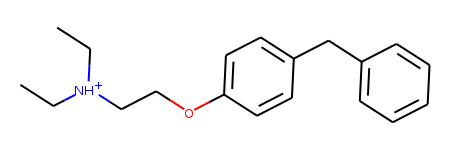

In [69]:
m = Chem.MolFromSmiles('CC[NH+](CC)CCOc1ccc(cc1)Cc2ccccc2')
m

And here are the fragments from doing a BRICS analysis:

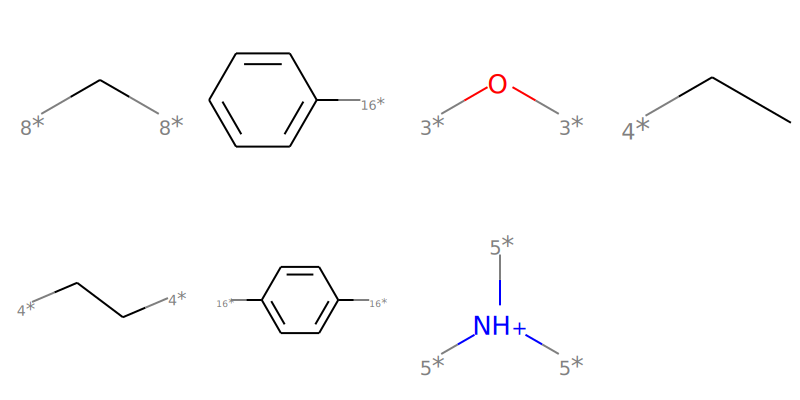

In [72]:
pieces = [Chem.MolFromSmiles(x) for x in BRICS.BRICSDecompose(m)]
Draw.MolsToGridImage(pieces,molsPerRow=4)

The isotope labels on the molecules provide information about the type of bond that was broken and can be used later (using `BRICS.BRICSBuild()`) to build new molecules. For example, the rules allow a bond to be formed between an atom connected to a `[4*]` and an atom connected to a `[5*]`.

One important characteristic (I hesitate to use "feature" in this context) of the current RDKit BRICS implementation that impacts this analysis is that only unique fragments are returned. So we only get one `[4*]CC` fragment for that molecule above, even though it appears in the molecule twice.

So the analysis below is of the most common chemical words, but we only count frequency based on the number of molecules they appear in, not *how often* they appear in those molecules.

# The computation

We're going to use some parallel processing, so bring that stuff in:

In [4]:
from ipyparallel import Client
rc = Client()
dview = rc[:]
with dview.sync_imports():
    from rdkit import Chem
    from rdkit.Chem import BRICS
    import dbm,struct,os

importing Chem from rdkit on engine(s)
importing BRICS from rdkit.Chem on engine(s)
importing dbm on engine(s)
importing struct on engine(s)
importing os on engine(s)


The input is the SMILES files for the individual ZINC tranches:

In [5]:
infs = glob.glob('/scratch/RDKit_git/Data/Zinc15/split_files/*.smi')
print(len(infs))
infs[:5]

120


['/scratch/RDKit_git/Data/Zinc15/split_files/zinc15_HG.smi',
 '/scratch/RDKit_git/Data/Zinc15/split_files/zinc15_FG.smi',
 '/scratch/RDKit_git/Data/Zinc15/split_files/zinc15_JD.smi',
 '/scratch/RDKit_git/Data/Zinc15/split_files/zinc15_DD.smi',
 '/scratch/RDKit_git/Data/Zinc15/split_files/zinc15_AI.smi']

In [49]:
def process_file(fname):
    """
    This runs through the molecules in a SMILES file and keeps track of the BRICS
    fragments that they produce and the counts of those fragments.
    
    The results are stored in a dbm database. 
    """
    outfname = os.path.splitext(fname)[0] + '.dbm'
    res = 0
    with open(fname,'r') as inf:
        inf.readline() # header
        nDone=0
        with dbm.open(outfname,flag='n') as db:
            for inl in inf:
                m = Chem.MolFromSmiles(inl.split()[0])
                nDone += 1
                if m is None or m.GetNumHeavyAtoms()>60: continue
                s = BRICS.BRICSDecompose(m)
                for entry in s:
                    cnt = struct.unpack('I',db.get(entry,b'\0\0\0\0'))[0]+1
                    db[entry] = struct.pack('I',cnt)
            res = len(db.keys())
    return res   

Let's get a sence of how long this might take by running one of the really small files:

In [32]:
import time
t1 = time.time();process_file('/scratch/RDKit_git/Data/Zinc15/split_files/zinc15_AB.smi');print("%.2f"%(time.time()-t1))

329.65


Tranche AB only has 177404 molecules (and they are small molecules), but that already takes >5 minutes. Doing the full dataset is going to take a *long* time....

We run the whole thing like this:

    counts = dview.map_sync(process_file,infs)

However, this is a big dataset (about 110 million molecules) and that takes a couple of days to run on my machine, (using up to 6 threads). So this isn't really interactive. I started it and then came back in a couple of days to work up the data.

# Initial workup of the results

## How many unique fragments are there?

To get this we need to process each of the dbm files and create one giant dictionary:

In [9]:
from collections import defaultdict
all_counts = defaultdict(int)
for i,fname in enumerate(infs):
    print(i+1,fname,len(all_counts.keys()))
    dbname = os.path.splitext(fname)[0] + '.dbm'
    with dbm.open(dbname,flag='r') as db:
        for key,val in db.items():
            all_counts[key]+=struct.unpack('I',val)[0]

1 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_HG.smi 0
2 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_FG.smi 27741
3 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_JD.smi 63895
4 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_DD.smi 68815
5 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_AI.smi 105976
6 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_BE.smi 106992
7 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_KI.smi 200809
8 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_GE.smi 211119
9 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_IB.smi 220289
10 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_EA.smi 220930
11 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_IJ.smi 222217
12 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_AE.smi 231661
13 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_AJ.smi 280129
14 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_KF.smi 280251
15 /scratch/RDKit_git/Data/Zinc15/split_files/zinc15_CC.smi 283191
16 /scratch/

In [132]:
import pickle
pickle.dump(all_counts,open('../data/chemical_words_all_counts.pkl','wb+'))

In [53]:
itms = sorted(((y,x) for x,y in all_counts.items()),reverse=True)
len(itms)

1619397

So we got 1.6 million unique fragments from the dataset.

Let's look at the most and least frequent fragments:

In [54]:
itms[:10]

[(64028217, b'[5*]N[5*]'),
 (29499142, b'[1*]C([6*])=O'),
 (27159161, b'[4*]C[8*]'),
 (21965118, b'[3*]O[3*]'),
 (18976763, b'[3*]OC'),
 (13840866, b'[1*]C([1*])=O'),
 (12942186, b'[16*]c1ccccc1'),
 (10405361, b'[16*]c1ccc([16*])cc1'),
 (10357103, b'[4*]CC'),
 (7947669, b'[5*]N([5*])C')]

In [55]:
itms[-10:]

[(1, b'B1BBB[C@@H]2BB[C@@H](BBB1)B2'),
 (1, b'B1BBBB[C@H]2B[C@H]2BBBB1'),
 (1, b'B1BBBB[C@H]2B[C@@H]2BBBB1'),
 (1, b'B1BBBB[C@@H]2B[C@H]2BBBB1'),
 (1, b'B1BBBBC2BC(BBB1)B2'),
 (1, b'B1BBBBB/C=C\\BBBB1'),
 (1, b'B1BBBBB/C=C/BBBB1'),
 (1, b'B1=BB=C=B1'),
 (1, b'B12B3B4B1C234'),
 (1, b'B(C1CCCCC1)C1CCCCC1')]

It's nicer to actually look at the molecules:

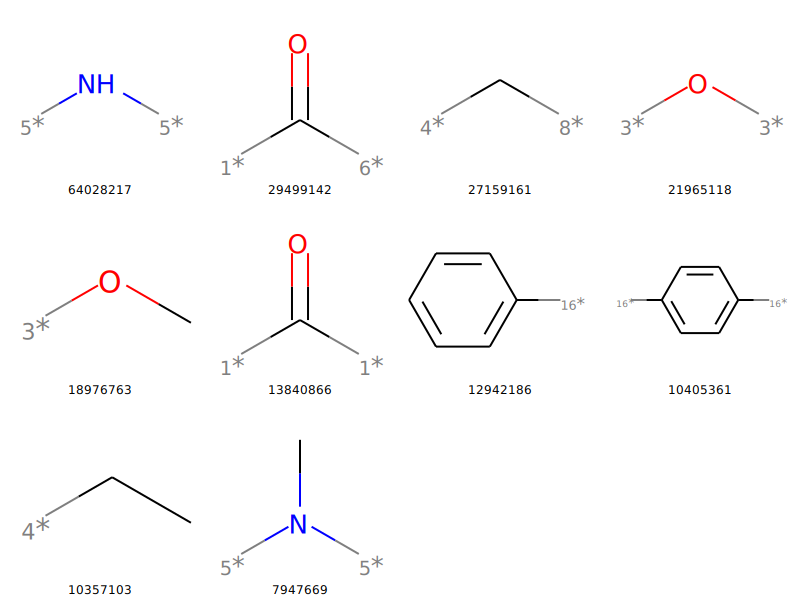

In [62]:
tc,ts = zip(*itms[:10])
Draw.MolsToGridImage([Chem.MolFromSmiles(x.decode('UTF-8')) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

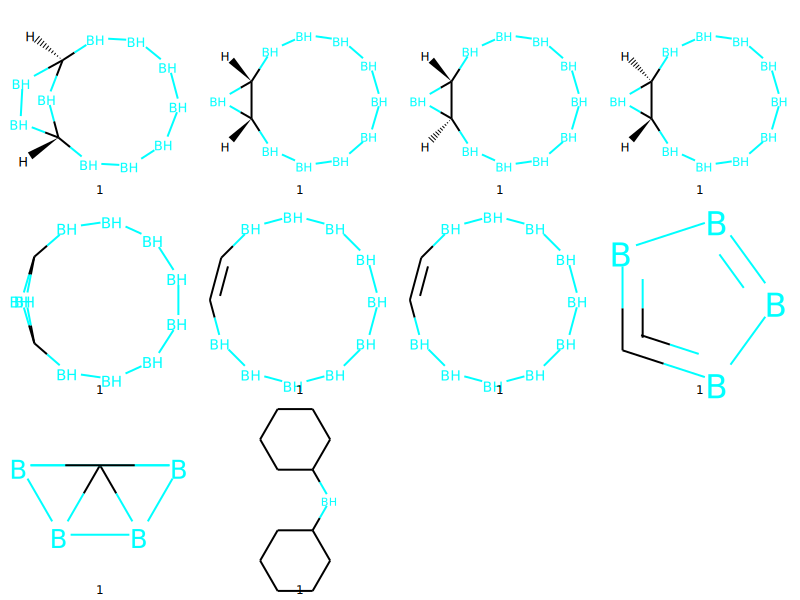

In [63]:
tc,ts = zip(*itms[-10:])
Draw.MolsToGridImage([Chem.MolFromSmiles(x.decode('UTF-8')) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

Ew... those aren't particularly nice. Good thing we won't be doing much with them.

Look at the number of times each frequency appears:

In [32]:
import math
def summarize(pts,maxCount=1e7):
    bins=[0]*int(ceil(math.log10(maxCount)))
    for cnt,smi in itms:
        if cnt>maxCount:
            bins[-1]+=1
        else:
            bins[int(floor(math.log10(cnt)))]+=1
    return bins
bins=summarize(itms)

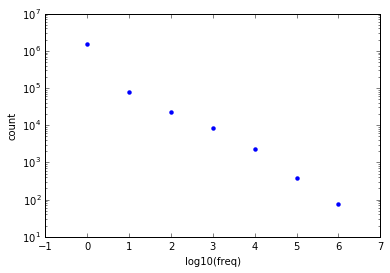

In [82]:
scatter(list(range(len(bins))),bins,lw=0)
_=yscale('log')
_=xlabel('log10(freq)')
_=ylabel('count')

[The wikipedia says](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot) I'm not supposed to call that a power-law distribution, so I'll go with "power-law-like". Is that a thing?

Let's clean up the data a little bit: remove molecules without attachment points and then get rid of the isomeric markers that describe what type of bond was broken:

In [49]:
import re
expr = re.compile(r'[0-9]+\*')
clean_counts = defaultdict(int)
nRejected=0
for k,v in all_counts.items():
    k = k.decode('UTF-8')
    if k.find('*')<0:
        nRejected +=1
        continue
    k = expr.sub('*',k)
    clean_counts[k]+=v

In [51]:
clean_itms = sorted([(v,k) for k,v in clean_counts.items()],reverse=True)
print(len(clean_itms))
clean_itms[:10]

869655


[(64028217, '[*]N[*]'),
 (43725178, '[*]C([*])=O'),
 (33363742, '[*]C[*]'),
 (21965118, '[*]O[*]'),
 (18976763, '[*]OC'),
 (16425583, '[*]CC'),
 (14531526, '[*]C(=O)C[*]'),
 (12942186, '[*]c1ccccc1'),
 (10405361, '[*]c1ccc([*])cc1'),
 (9220870, '[*]CC[*]')]

Most frequent fragments:

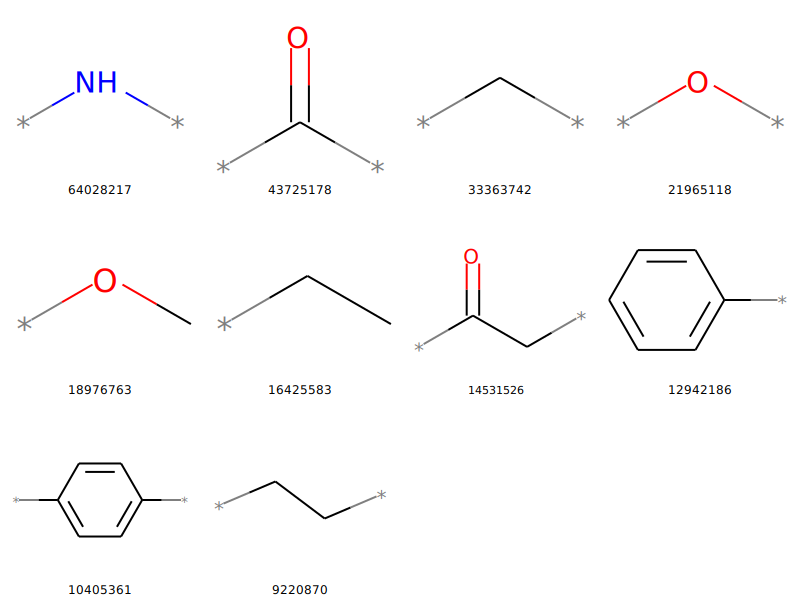

In [66]:
tc,ts = zip(*clean_itms[:10])
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

Least frequent:

In [68]:
clean_itms[-10:]

[(1, '[*]C(/C=C1\\Oc2ccc([*])cc2N1C)CC'),
 (1, '[*]C(/C=C1/Sc2ccccc2N1C)CC'),
 (1, '[*]C(/C=C1/Sc2ccc(Cl)cc2N1C)CC'),
 (1, '[*]C(/C=C/N(C)C)C(C)(C)C'),
 (1, '[*]C(/C=C/N(C)C)/C=C/N(C)C'),
 (1, '[*]C(/C(O)=N/S(=O)(=O)c1ccc(N)cc1)/C(O)=N/S(=O)(=O)c1ccc(N)cc1'),
 (1,
  '[*]C(/C(=N/[C@H]1Cc2ccc1cc2C)c1cccc(S(=O)(=O)O)c1)/C(=N/[C@H]1Cc2ccc1cc2C)c1cccc(S(=O)(=O)O)c1'),
 (1,
  '[*]C(/C(=N/[C@H]1Cc2ccc1cc2C)c1cccc(S(=O)(=O)O)c1)/C(=N/[C@@H]1Cc2ccc1cc2C)c1cccc(S(=O)(=O)O)c1'),
 (1,
  '[*]C(/C(=N/[C@@H]1Cc2ccc1cc2C)c1cccc(S(=O)(=O)O)c1)/C(=N/[C@@H]1Cc2ccc1cc2C)c1cccc(S(=O)(=O)O)c1'),
 (1, '[*]C(/C(=N/O)c1ccccc1)/C(=N\\O)c1ccccc1')]

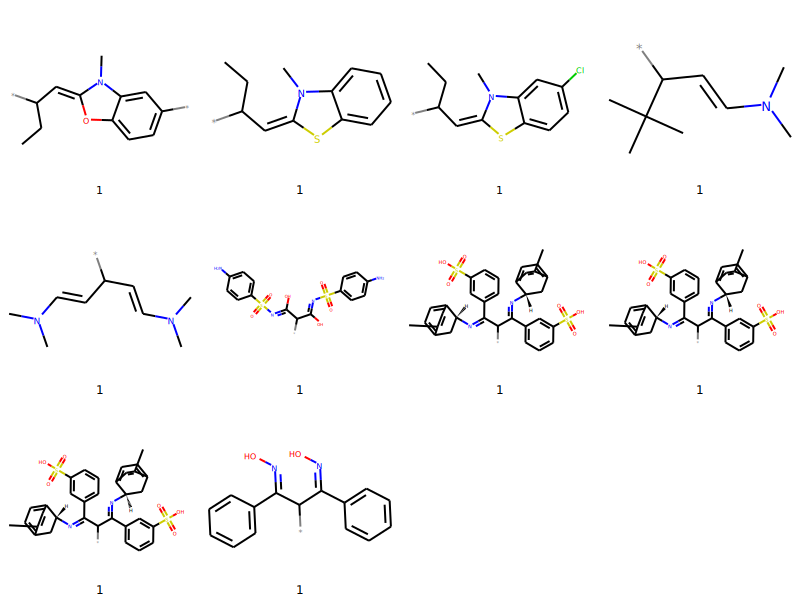

In [67]:
tc,ts = zip(*clean_itms[-10:])
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

Ok, so what about the 1000 most common BRICS fragments?

In [74]:
thousand = clean_itms[:1000]

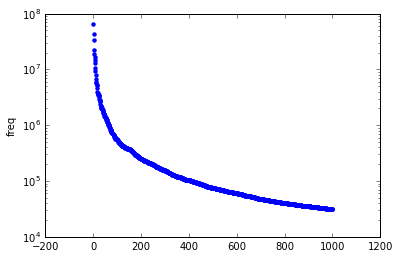

In [84]:
scatter(range(1000),[x[0] for x in thousand],lw=0)
_=yscale('log')
_=ylabel('freq')

That's a steep drop off, but even the least common "word" appears >31000 times in our dataset:

In [83]:
thousand[-1]

(31447, '[*]n1ccc2cc([*])ccc21')

How many attachment points do those fragments have?

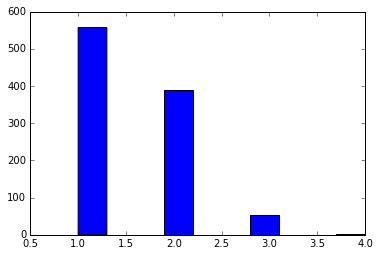

In [87]:
_=hist([y.count('*') for x,y in thousand])

Who's got 4?

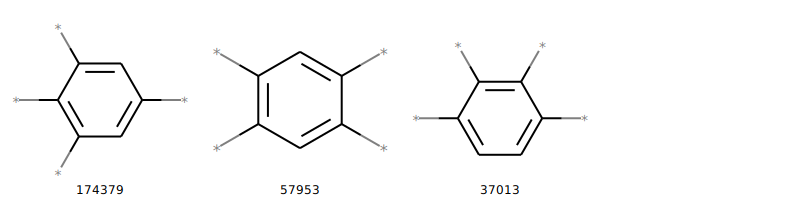

In [88]:
tmp = [x for x in thousand if x[1].count('*')==4]
tc,ts = zip(*tmp)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

What about 3?

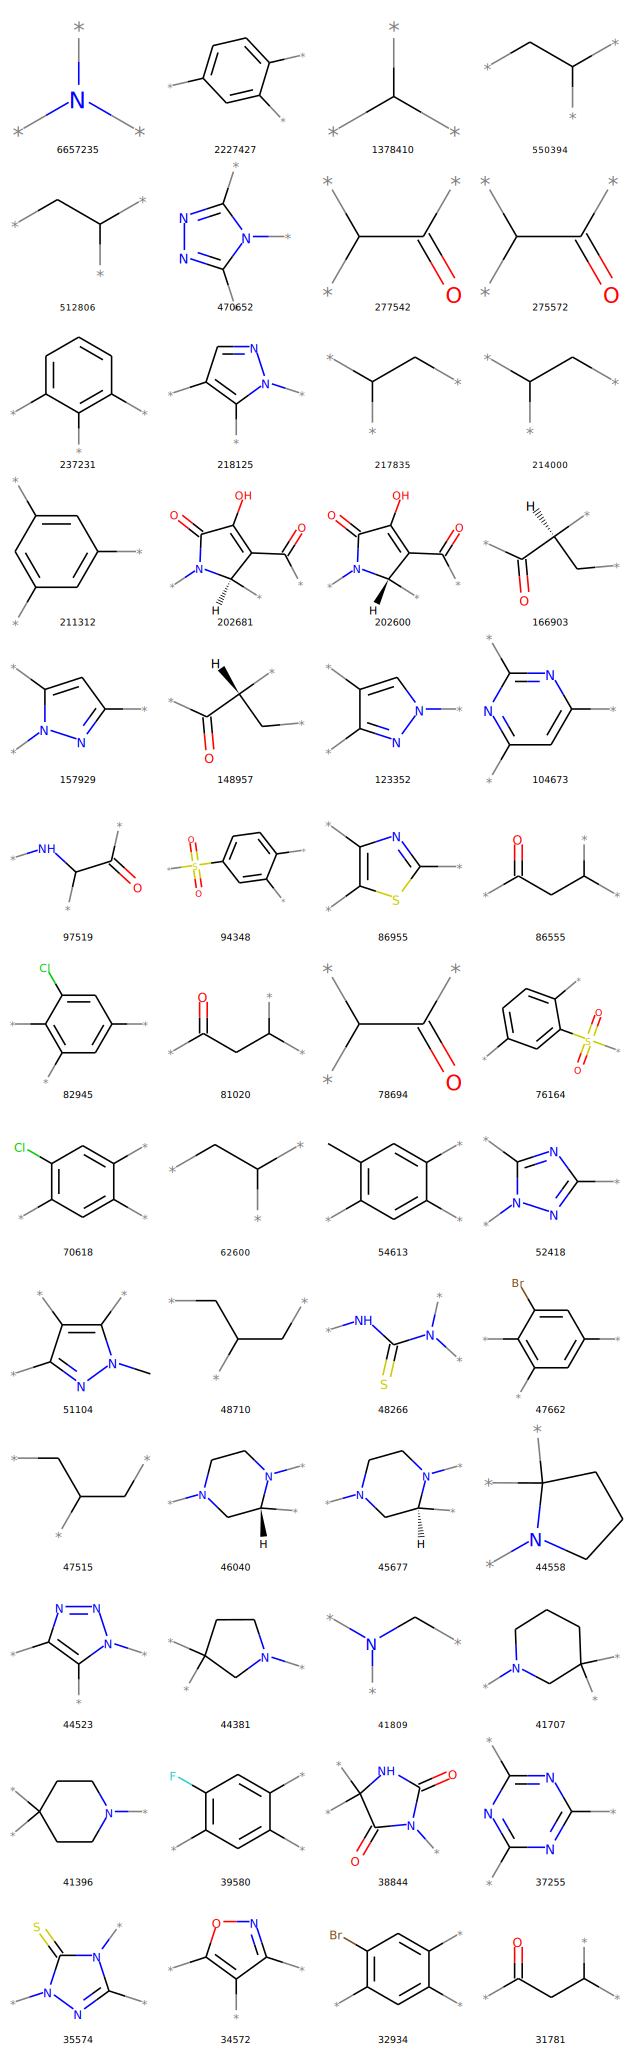

In [89]:
tmp = [x for x in thousand if x[1].count('*')==3]
tc,ts = zip(*tmp)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

There are some examples in there that look like duplicates. That's just happening because the removal of the isotopic labels has made some stereoceneters look like they are no longer stereocenters when the SMILES is processed:

In [92]:
[x for x in thousand if x[1].count('*')==3][10:12]

[(217835, '[*][C@H]([*])C[*]'), (214000, '[*][C@@H]([*])C[*]')]

We can do at least a little bit about that by sanitizing the molecules differently:

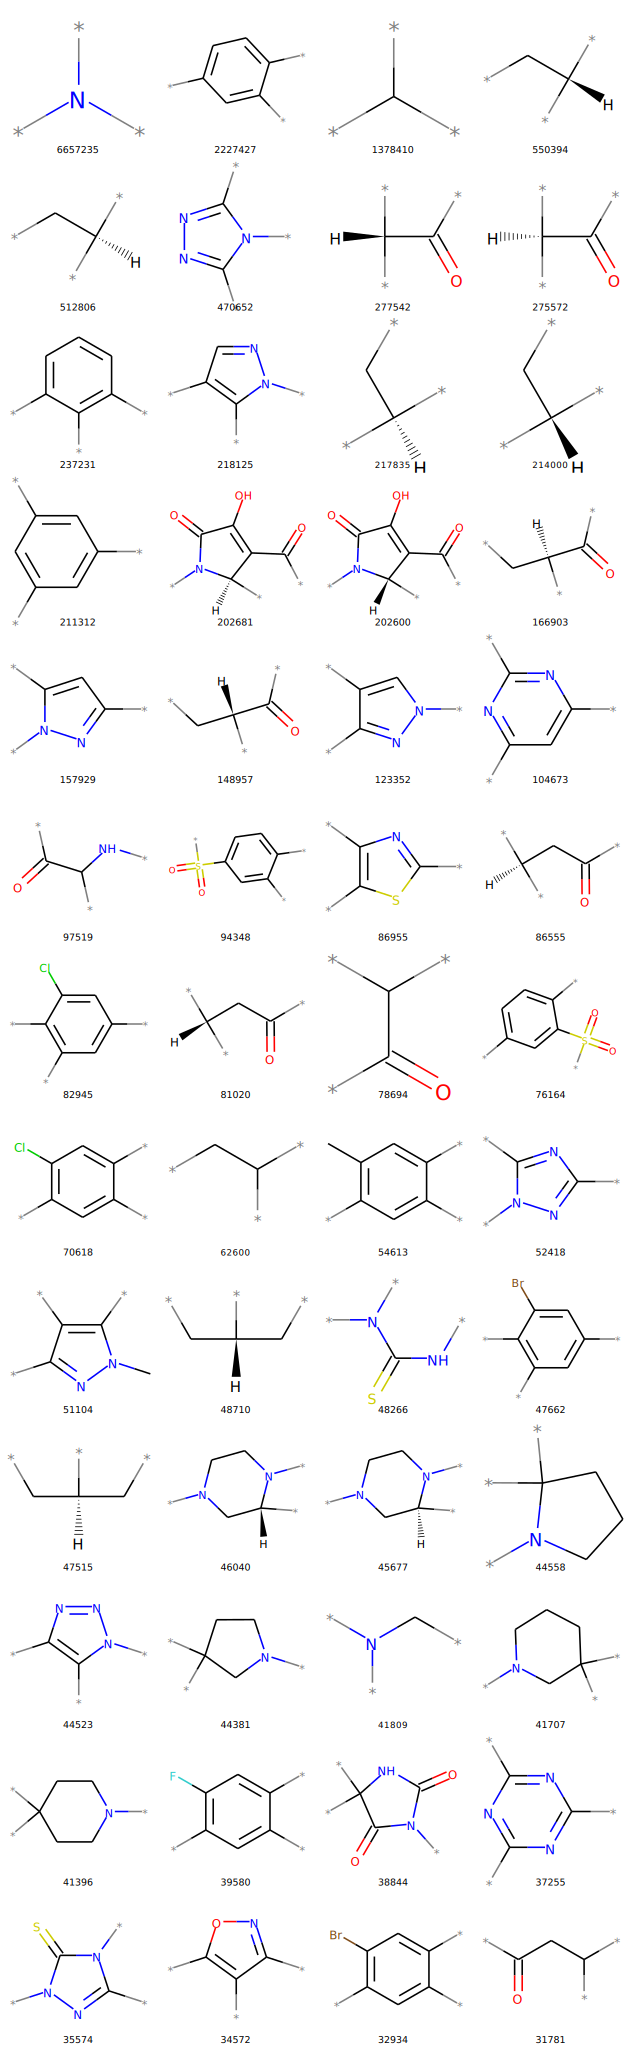

In [93]:
tc,ts = zip(*tmp)
tms = [Chem.MolFromSmiles(x,sanitize=False) for x in ts]
[Chem.SanitizeMol(x) for x in tms]
Draw.MolsToGridImage(tms,molsPerRow=4,legends=[str(x) for x in tc])

Still, this does highlight a minor problem with the simple string-manipulation approach to removing the isotopes from the fragments. Let's fix that problem by actually re-building the molecules. This time we'll remove stereochemistry that is no longer present when the isotope labels are removed from the dummies.

We've got a bunch of these, so this takes a while:

In [94]:
clean_counts2 = defaultdict(int)
nRejected=0
for k,v in all_counts.items():
    k = k.decode('UTF-8')
    if k.find('*')<0:
        nRejected +=1
        continue
    k = Chem.MolToSmiles(Chem.MolFromSmiles(expr.sub('*',k)),True)
    clean_counts2[k]+=v

In [133]:
import pickle
pickle.dump(clean_counts2,open('../data/chemical_words_clean_counts2.pkl','wb+'))

In [97]:
clean_itms2 = sorted([(v,k) for k,v in clean_counts2.items()],reverse=True)
print(len(clean_itms2),len(clean_itms))
thousand = clean_itms2[:1000]

858146 869655


So we did remove a few.

Let's look at what's left:

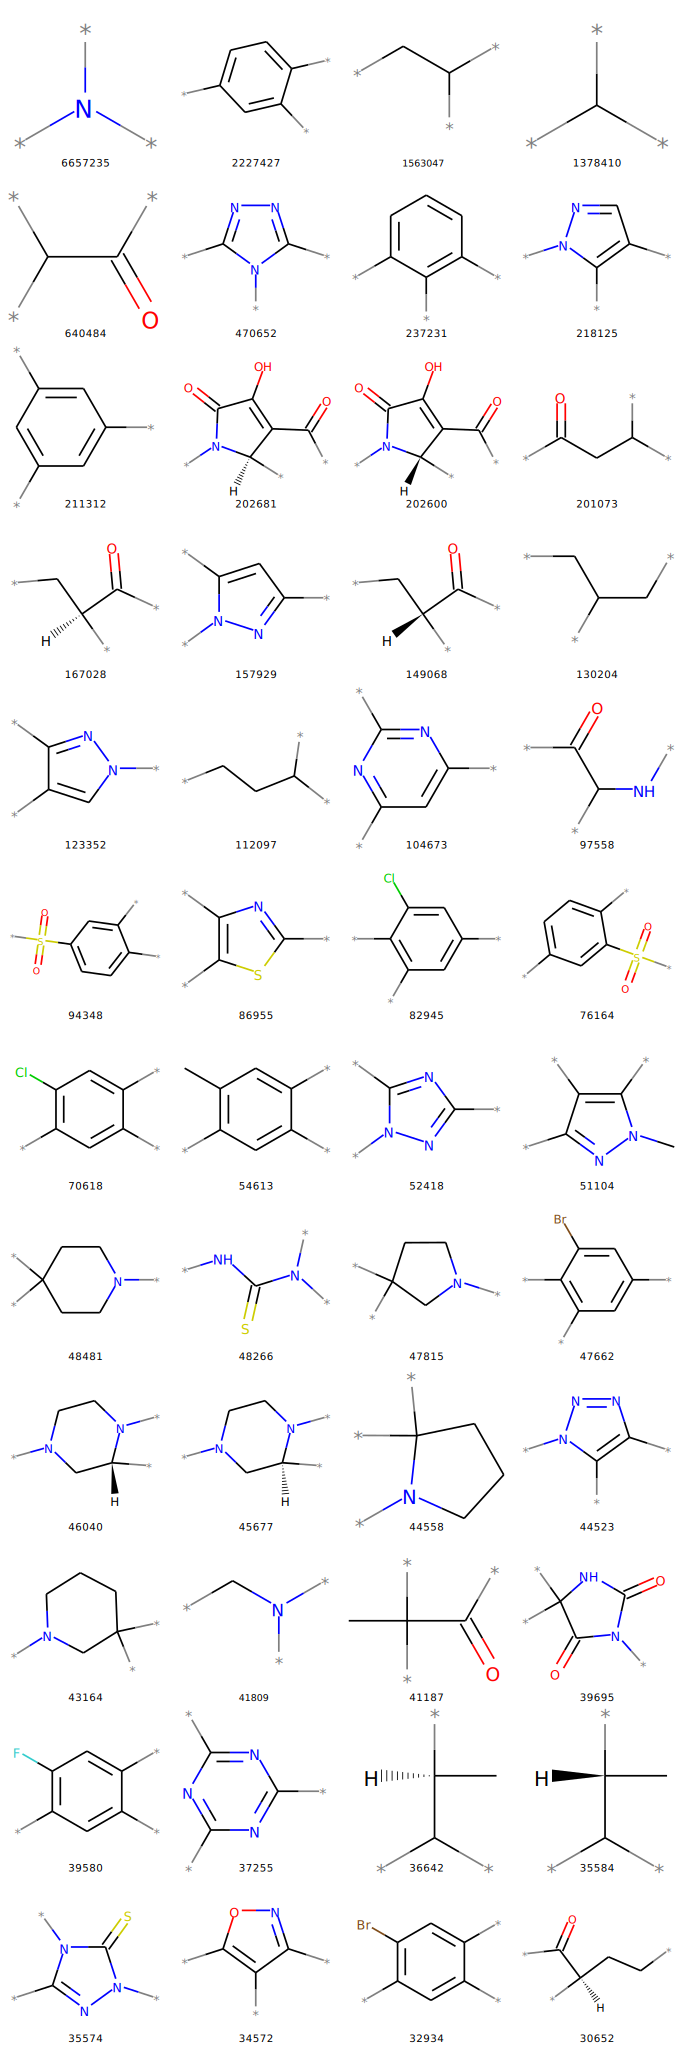

In [98]:
tmp = [x for x in thousand if x[1].count('*')==3]
tc,ts = zip(*tmp)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

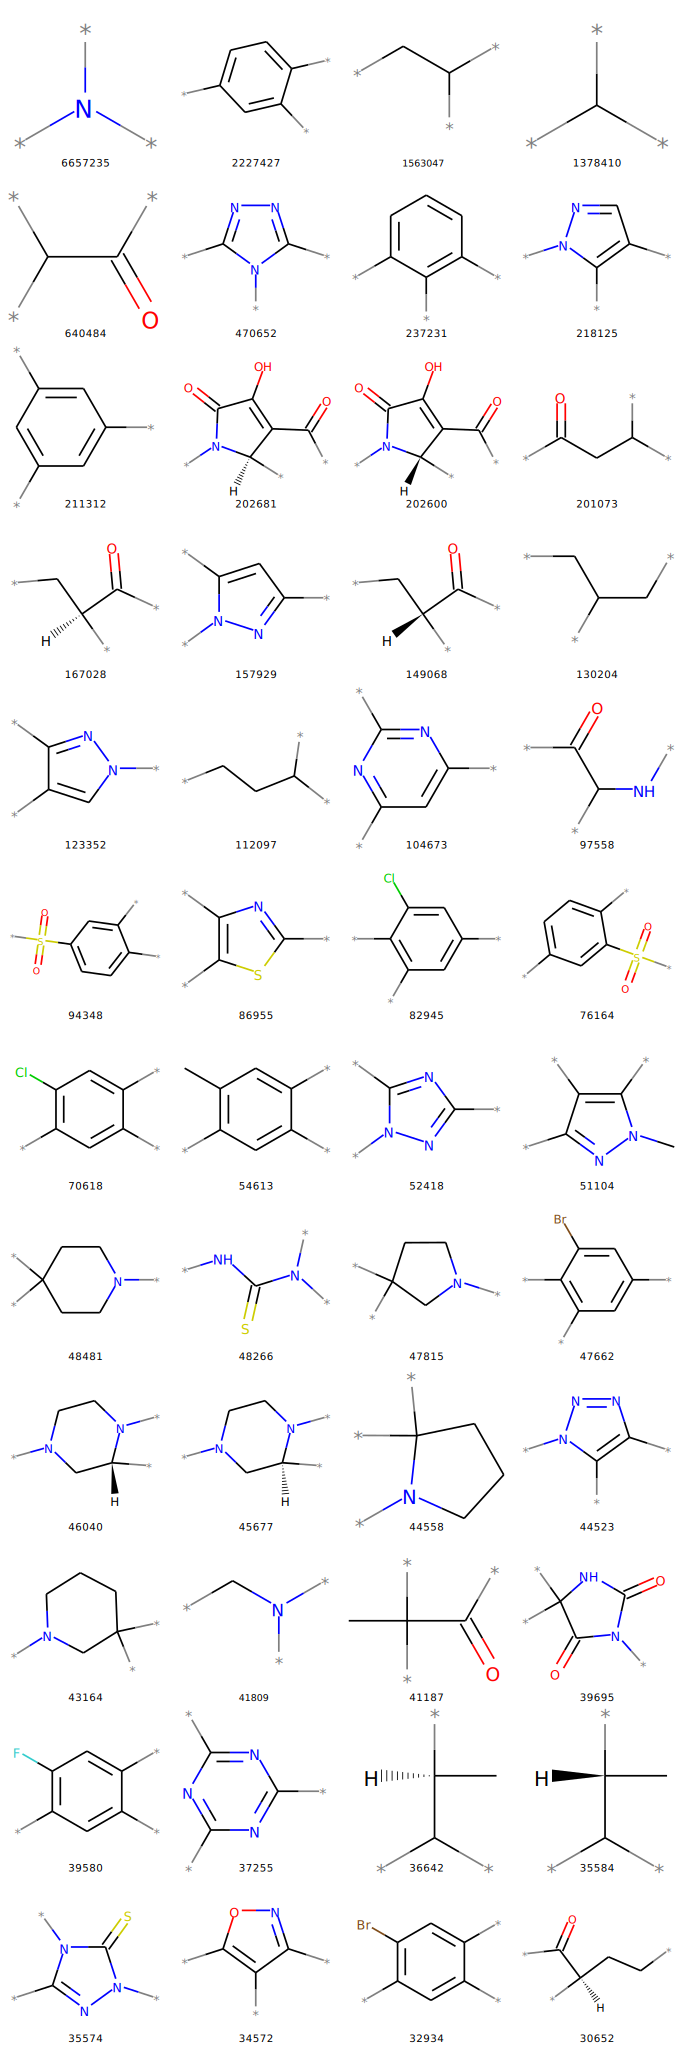

In [101]:
tc,ts = zip(*tmp)
tms = [Chem.MolFromSmiles(x) for x in ts]
Draw.MolsToGridImage(tms,molsPerRow=4,legends=[str(x) for x in tc])

Write out our thousand common chemical words, this file will be in the github repo:

In [103]:
outf=open('../data/thousand_words.no_iso.smi','w+')
for tc,ts in thousand:
    print(ts,tc,file=outf)

I'm going to want to use the ones that are still isotopically labeled later, so write those out too. This file will also be in the github repo:

In [108]:
t_itms = [(v,k.decode('UTF-8')) for k,v in all_counts.items()]
iso_itms = sorted([(v,k) for v,k in t_itms if k.count('*')>0],reverse=True)
print(len(iso_itms))
thousand_iso = iso_itms[:1000]
outf=open('../data/thousand_words.iso.smi','w+')
for tc,ts in thousand_iso:
    print(ts,tc,file=outf)

907375


As a teaser, let's make some new molecules:

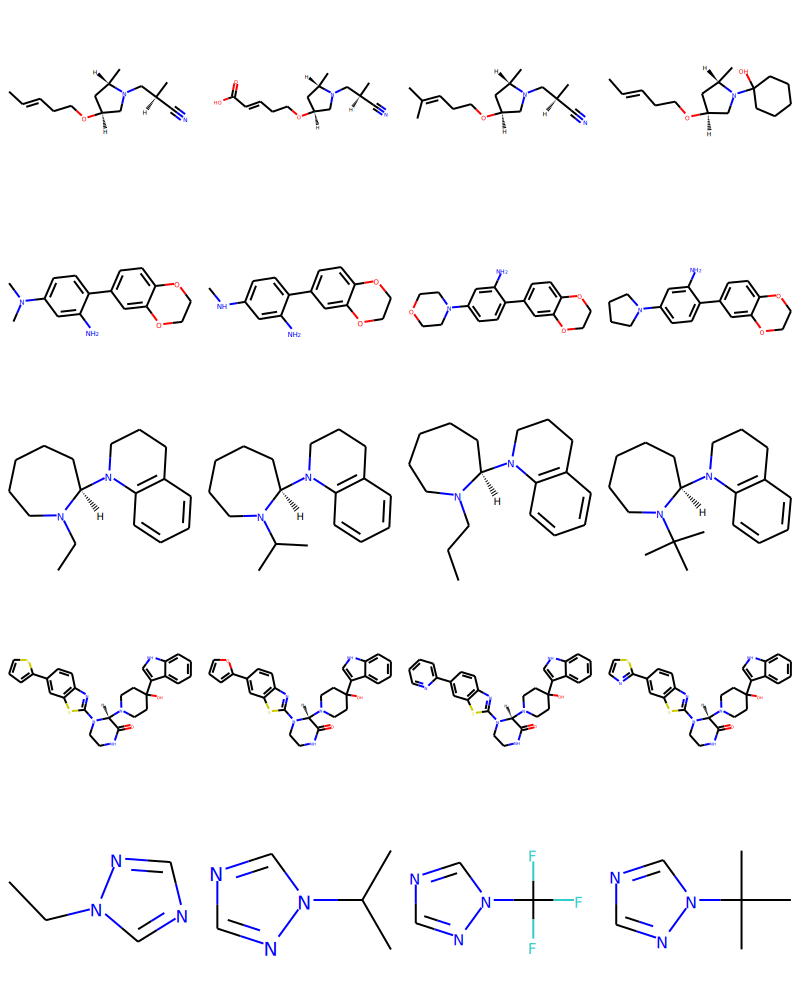

In [131]:
import random
thousand_iso_frags = [Chem.MolFromSmiles(y) for x,y in thousand_iso]
new_mols = []
# the building algorithm tends to explore around a given point, 
# so let's pick a number of starting points and enumerate a few molecules
# around each of them:
for i in range(5):
    random.seed(0x1234+i)
    brics_gen = BRICS.BRICSBuild(thousand_iso_frags)
    for tm in [next(brics_gen) for x in range(4)]:
        try:
            Chem.SanitizeMol(tm)
        except:
            continue
        new_mols.append(tm)
Draw.MolsToGridImage(new_mols,molsPerRow=4)

That's enough for now...